In [89]:
import numpy as np
import json
import matplotlib.pyplot as plt
import math

In [90]:
with open('..\\data\\oscar_wind_data_U.json', 'r') as datafile:
    wind_u = json.load(datafile)[0]['data']

with open('..\\data\\oscar_wind_data_V.json', 'r') as datafile:
    wind_v = json.load(datafile)[0]['data']

with open('..\\data\\oscar_current_data_U.json', 'r') as datafile:
    current_u = json.load(datafile)[0]['data']

with open('..\\data\\oscar_current_data_V.json', 'r') as datafile:
    current_v = json.load(datafile)[0]['data']

print(wind_u[0])
print(wind_v[0])
print(current_u[0])
print(current_v[0])

-4.76
0.75
None
None


In [100]:
wind_vf = np.zeros((181, 360, 2))
current_vf = np.zeros((481, 1080, 2))
wind_mag = np.zeros((181, 360))
current_mag = np.zeros((481, 1080))
is_land = np.zeros((481, 1080))

for i in range(len(current_u)):
    r = int(i / 1080)
    c = int(i % 1080)
    if (current_u[i] != None and current_v[i] != None):
        current_vf[r][c] = [current_u[i], current_v[i]]
        current_mag[r][c] = 0.5 + np.sqrt(pow(current_u[i], 2) + pow(current_v[i], 2))
    else:
        is_land[r][c] += 1

for i in range(len(wind_u)):
    r = int(i / 360)
    c = int(i % 360)
    wind_vf[r][c] = [wind_u[i], wind_v[i]]
    wind_mag[r][c] = np.sqrt(pow(wind_u[i], 2) + pow(wind_v[i], 2))

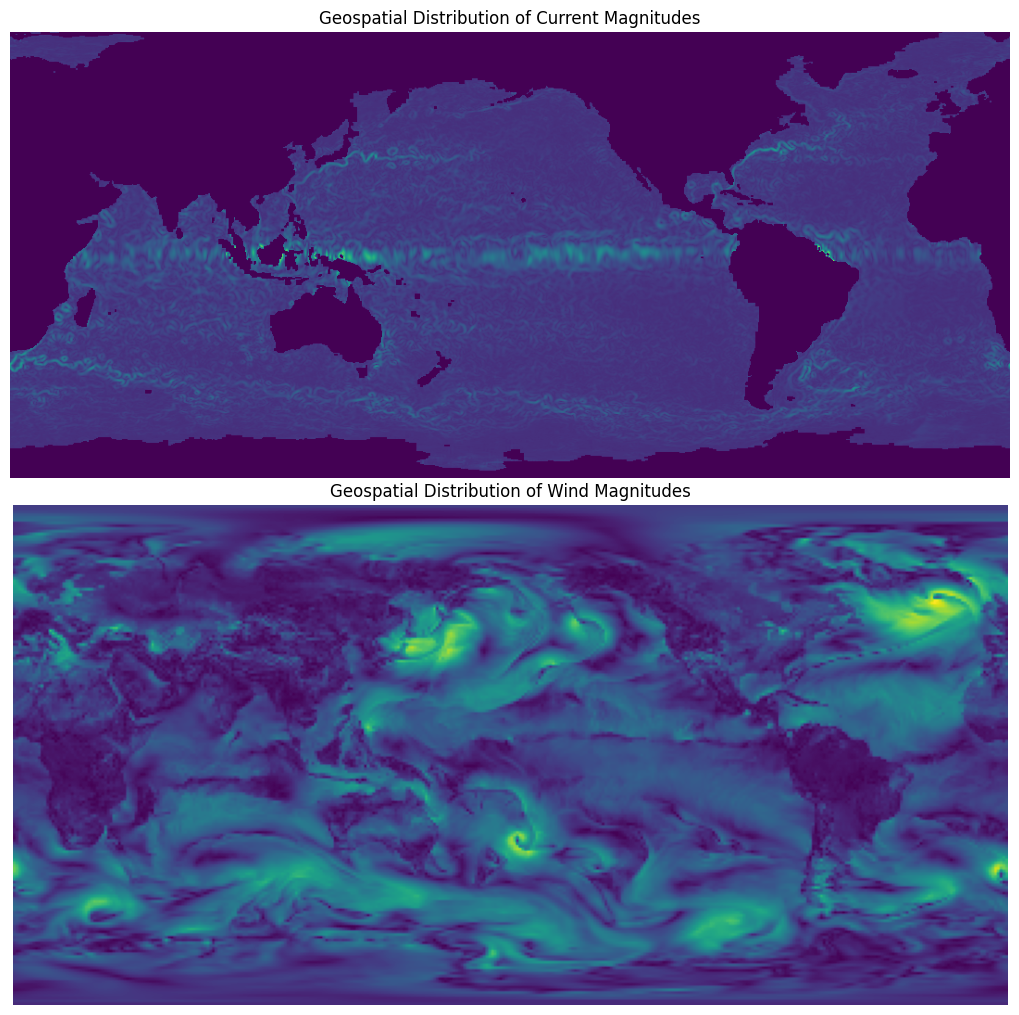

In [101]:

fig, ax = plt.subplots(2, figsize=(10, 10))
ax[0].imshow(current_mag)
ax[1].imshow(wind_mag)
ax[0].set_title('Geospatial Distribution of Current Magnitudes')
ax[1].set_title('Geospatial Distribution of Wind Magnitudes')
ax[0].axis('off')
ax[1].axis('off')
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0, 0)
#plt.savefig('wind_and_currents.png')

In [93]:
# latitude and longitude to r and c coordinates for current and wind

def ll_to_current_rc(lat, long):
    r = 3 * lat + 240
    if (long < 20):
        c = 3 * long + 1020
    if (long >= 20.0):
        c = 3 * long - 60
    return r, c, 480 - r

def ll_to_wind_rc(lat, long):
    r = lat + 90
    if (long >= 0):
        c = long
    else:
        c = long + 360
    return r, c, 180 - r

def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt(pow(x1-x2, 2) + pow(y1-y2, 2))

def current_vector(lat, long):
    r, c, y = ll_to_current_rc(lat, long)
    r1 = int(math.floor(r))
    r2 = int(math.ceil(r))
    c1 = int(math.floor(c))
    c2 = int(math.ceil(c))
    if (r1 == r2): r1 -= 1
    if (c1 == c2): c1 -= 1
    w_tl = 1.0 / (euclidean_distance(r, c, r1, c1) + 1e-3)
    w_tr = 1.0 / (euclidean_distance(r, c, r1, c2) + 1e-3)
    w_bl = 1.0 / (euclidean_distance(r, c, r2, c1) + 1e-3)
    w_br = 1.0 / (euclidean_distance(r, c, r2, c2) + 1e-3)
    u_tl = current_vf[r1][c1][0]
    u_tr = current_vf[r1][c2][0]
    u_bl = current_vf[r2][c1][0]
    u_br = current_vf[r2][c2][0]
    v_tl = current_vf[r1][c1][1]
    v_tr = current_vf[r1][c2][1]
    v_bl = current_vf[r2][c1][1]
    v_br = current_vf[r2][c2][1]

    u_comp = (u_tl * w_tl + u_tr * w_tr + u_bl * w_bl + u_br * w_br) / (np.sum([w_tl, w_tr, w_bl, w_br]))
    v_comp = (v_tl * w_tl + v_tr * w_tr + v_bl * w_bl + v_br * w_br) / (np.sum([w_tl, w_tr, w_bl, w_br]))

    return u_comp, v_comp

def direction_vector(latitude, longitude):
    du_c, dv_c = current_vector(latitude, longitude)
    w_r, w_c, w_y = ll_to_wind_rc(latitude, longitude)
    du_w, dv_w = wind_vf[round(w_r), round(w_c)]

    wind_to_current_ratio = 0.03

    return du_c + wind_to_current_ratio * du_w, dv_c + wind_to_current_ratio * dv_w

434


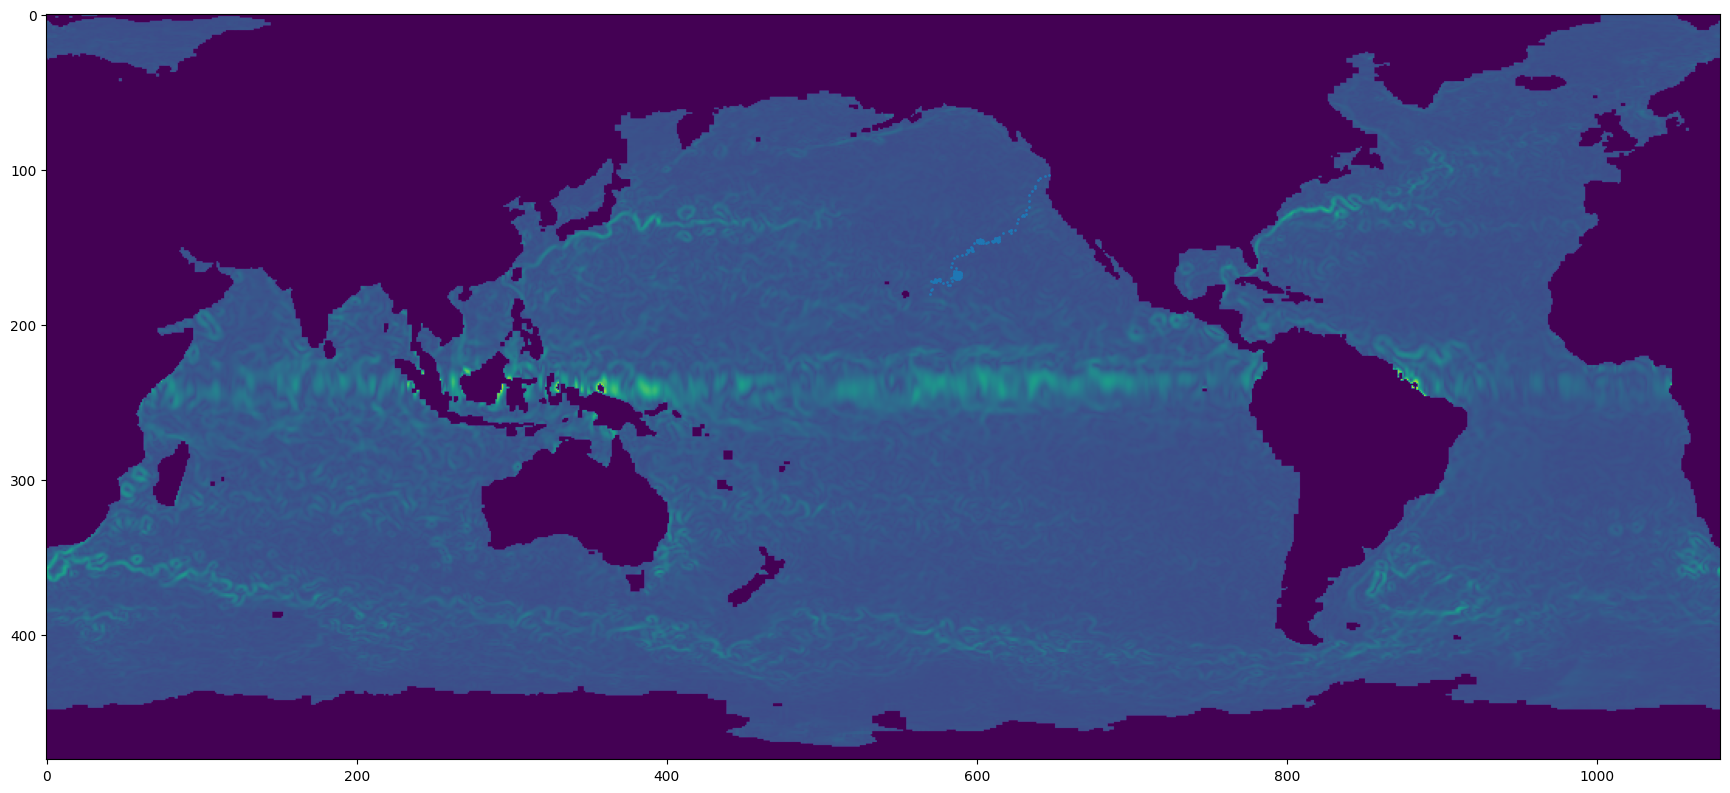

In [94]:
# single path forecasting

fig, ax = plt.subplots(1, figsize=(21.6, 9.82))
curr_map_c = []
curr_map_y = []

ax.imshow(current_mag)

latitude = 20.0
longitude = -150.0

step_scale_factor = 5
random_scale_factor = 1.0

terminate = False

for i in range(50000):
    c_r, c_c, c_y = ll_to_current_rc(latitude, longitude)
    if (is_land[int(c_y)][int(c_c)] > 0):
        break
    curr_map_y.append(c_y)
    curr_map_c.append(c_c)
    du, dv = current_vector(latitude, longitude)
    latitude += du * step_scale_factor + np.random.rand() * random_scale_factor
    latitude %= 180.0
    longitude += dv * step_scale_factor + np.random.rand() * random_scale_factor

ax.scatter(curr_map_c, curr_map_y, s=1)
print(len(curr_map_c))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


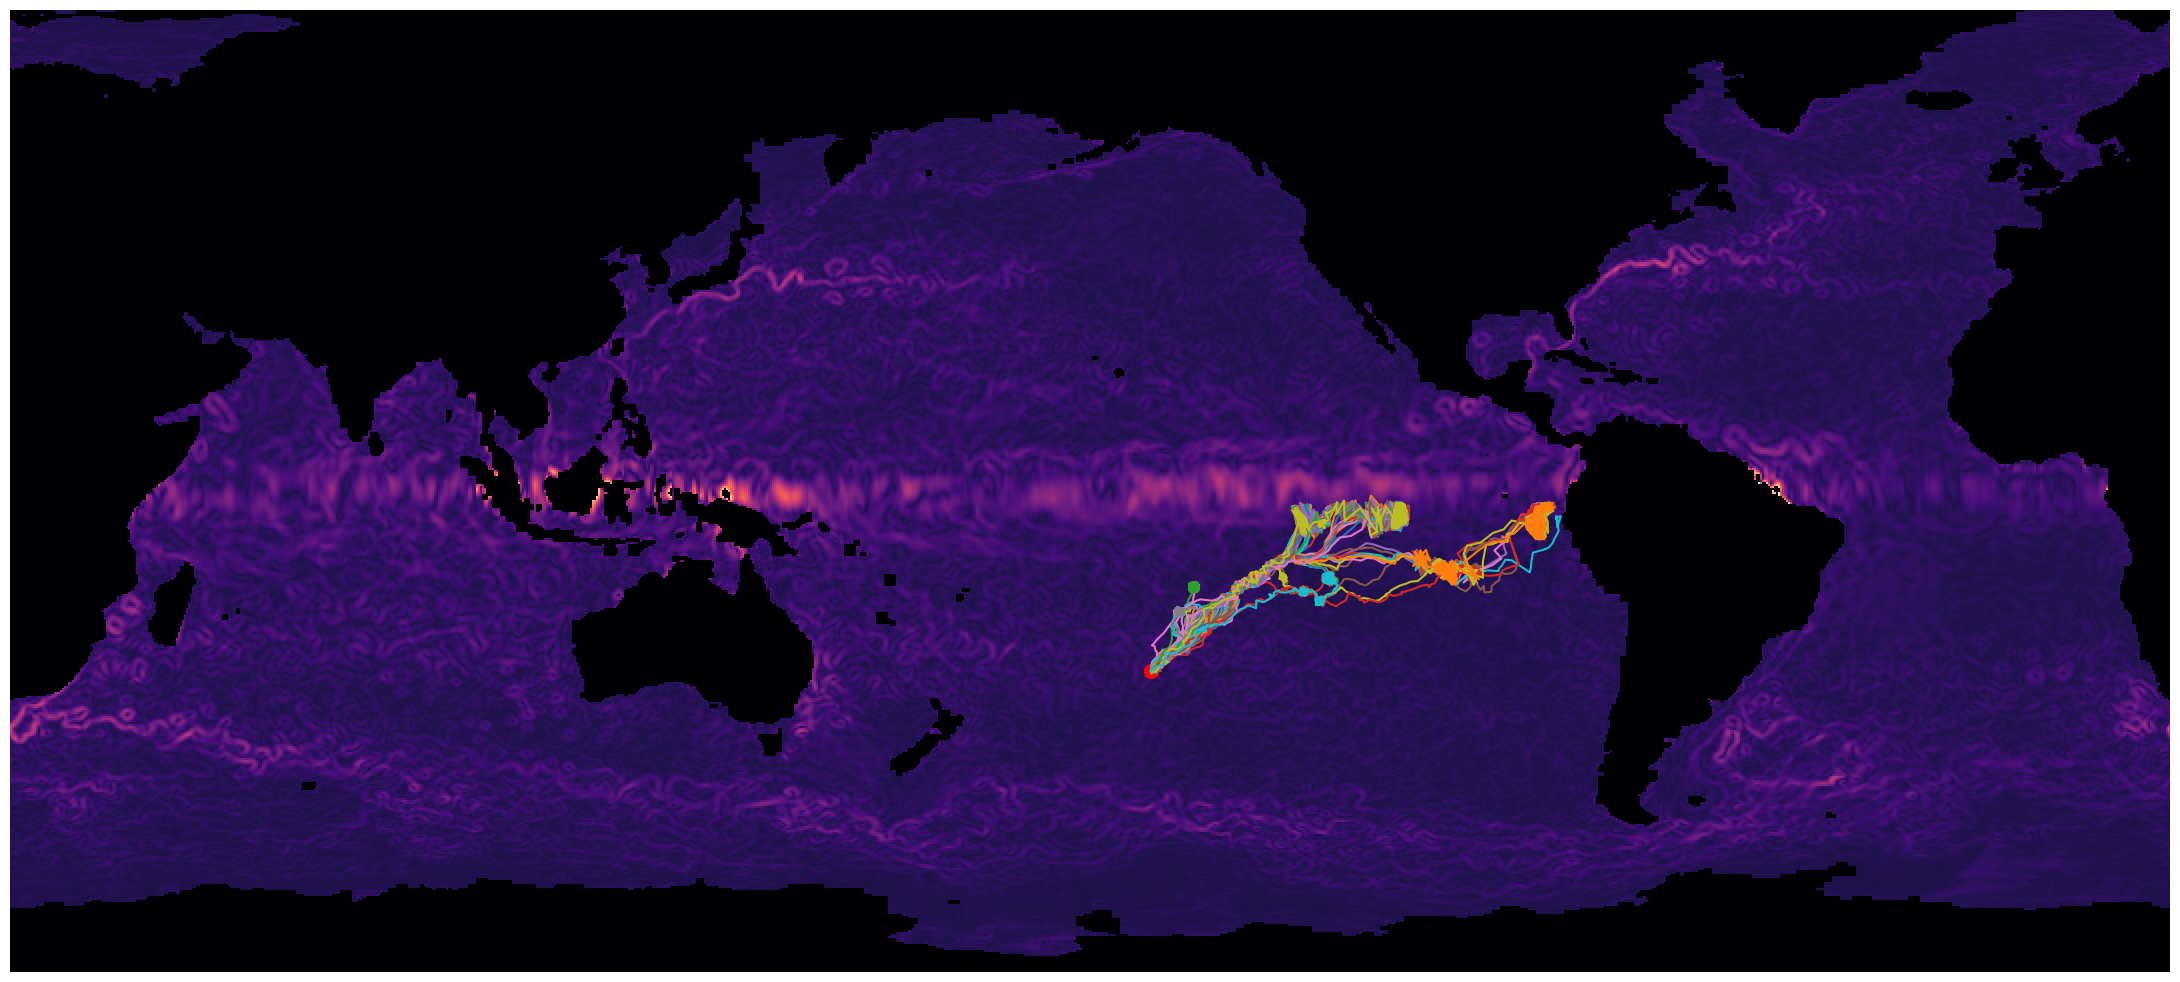

In [150]:
# analysis of random perturbation effect

fig, ax = plt.subplots(1, figsize=(21.6, 9.82))

ax.imshow(current_mag, cmap='magma')

step_scale_factor = 5
random_scale_factor = 1.0

latitude = -30.0
longitude = -150.0

init_r, init_c, init_y = ll_to_current_rc(latitude, longitude)

terminate = False

for o in range(100):
    print(o)
    latitude = -30.0
    longitude = -150.0
    curr_map_c = []
    curr_map_y = []
    for i in range(20000):
        c_r, c_c, c_y = ll_to_current_rc(latitude, longitude)
        if (is_land[int(c_y)][int(c_c)] > 0):
            break
        curr_map_y.append(c_y)
        curr_map_c.append(c_c)
        du, dv = current_vector(latitude, longitude)
        latitude += du * step_scale_factor + np.random.rand() * random_scale_factor
        longitude += dv * step_scale_factor + np.random.rand() * random_scale_factor

    ax.plot(curr_map_c, curr_map_y)

ax.scatter(init_c, init_y, c='r', s=100)
ax.set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0, 0)
#plt.savefig('random_perturbations.png')

1.0


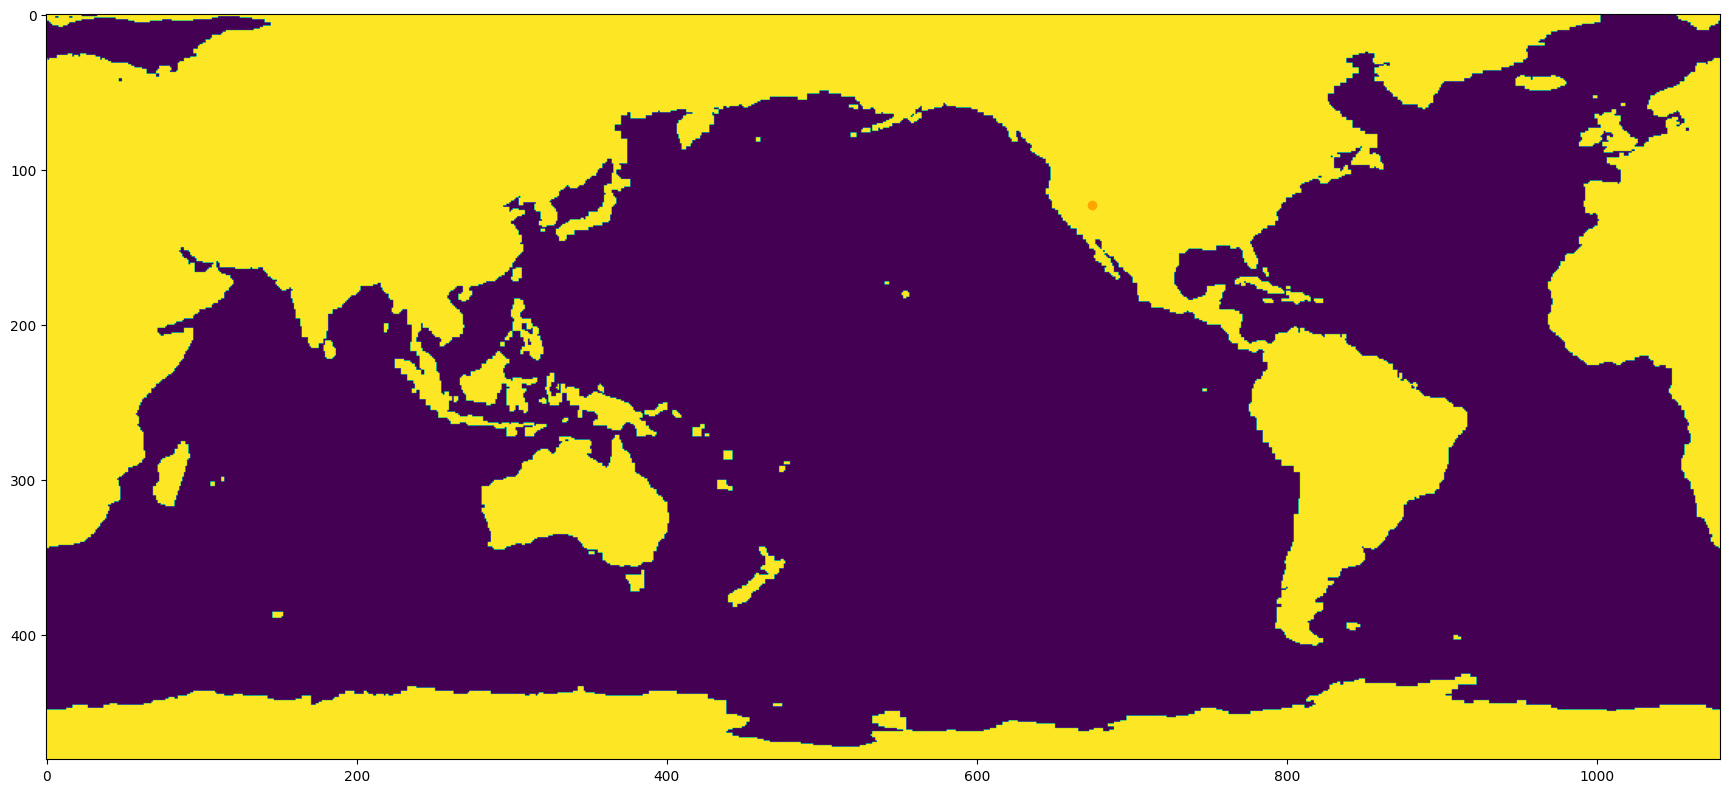

In [165]:
c_r, c_c, c_y = ll_to_current_rc(39, -115.3)
fig, ax = plt.subplots(1, figsize=(21.6, 9.82))

ax.imshow(is_land)

plt.scatter(c_c, c_y, c='orange')

print(is_land[int(c_y)][int(c_c)])

land_x = []
land_y = []

for r in range(0, 481):
    for c in range(0, 1080):
        if (is_land[r][c]):
            land_x.append(c)
            land_y.append(r)

0
latitude: 42.219908765262275 longitude: -57.22370344917009
path 0
path 1
path 2
path 3
path 4
path 5
path 6
path 7
path 8
path 9
1
latitude: 28.285243933060983 longitude: -170.53599431703805
path 0
path 1
path 2
path 3
path 4
path 5
path 6
path 7
path 8
path 9


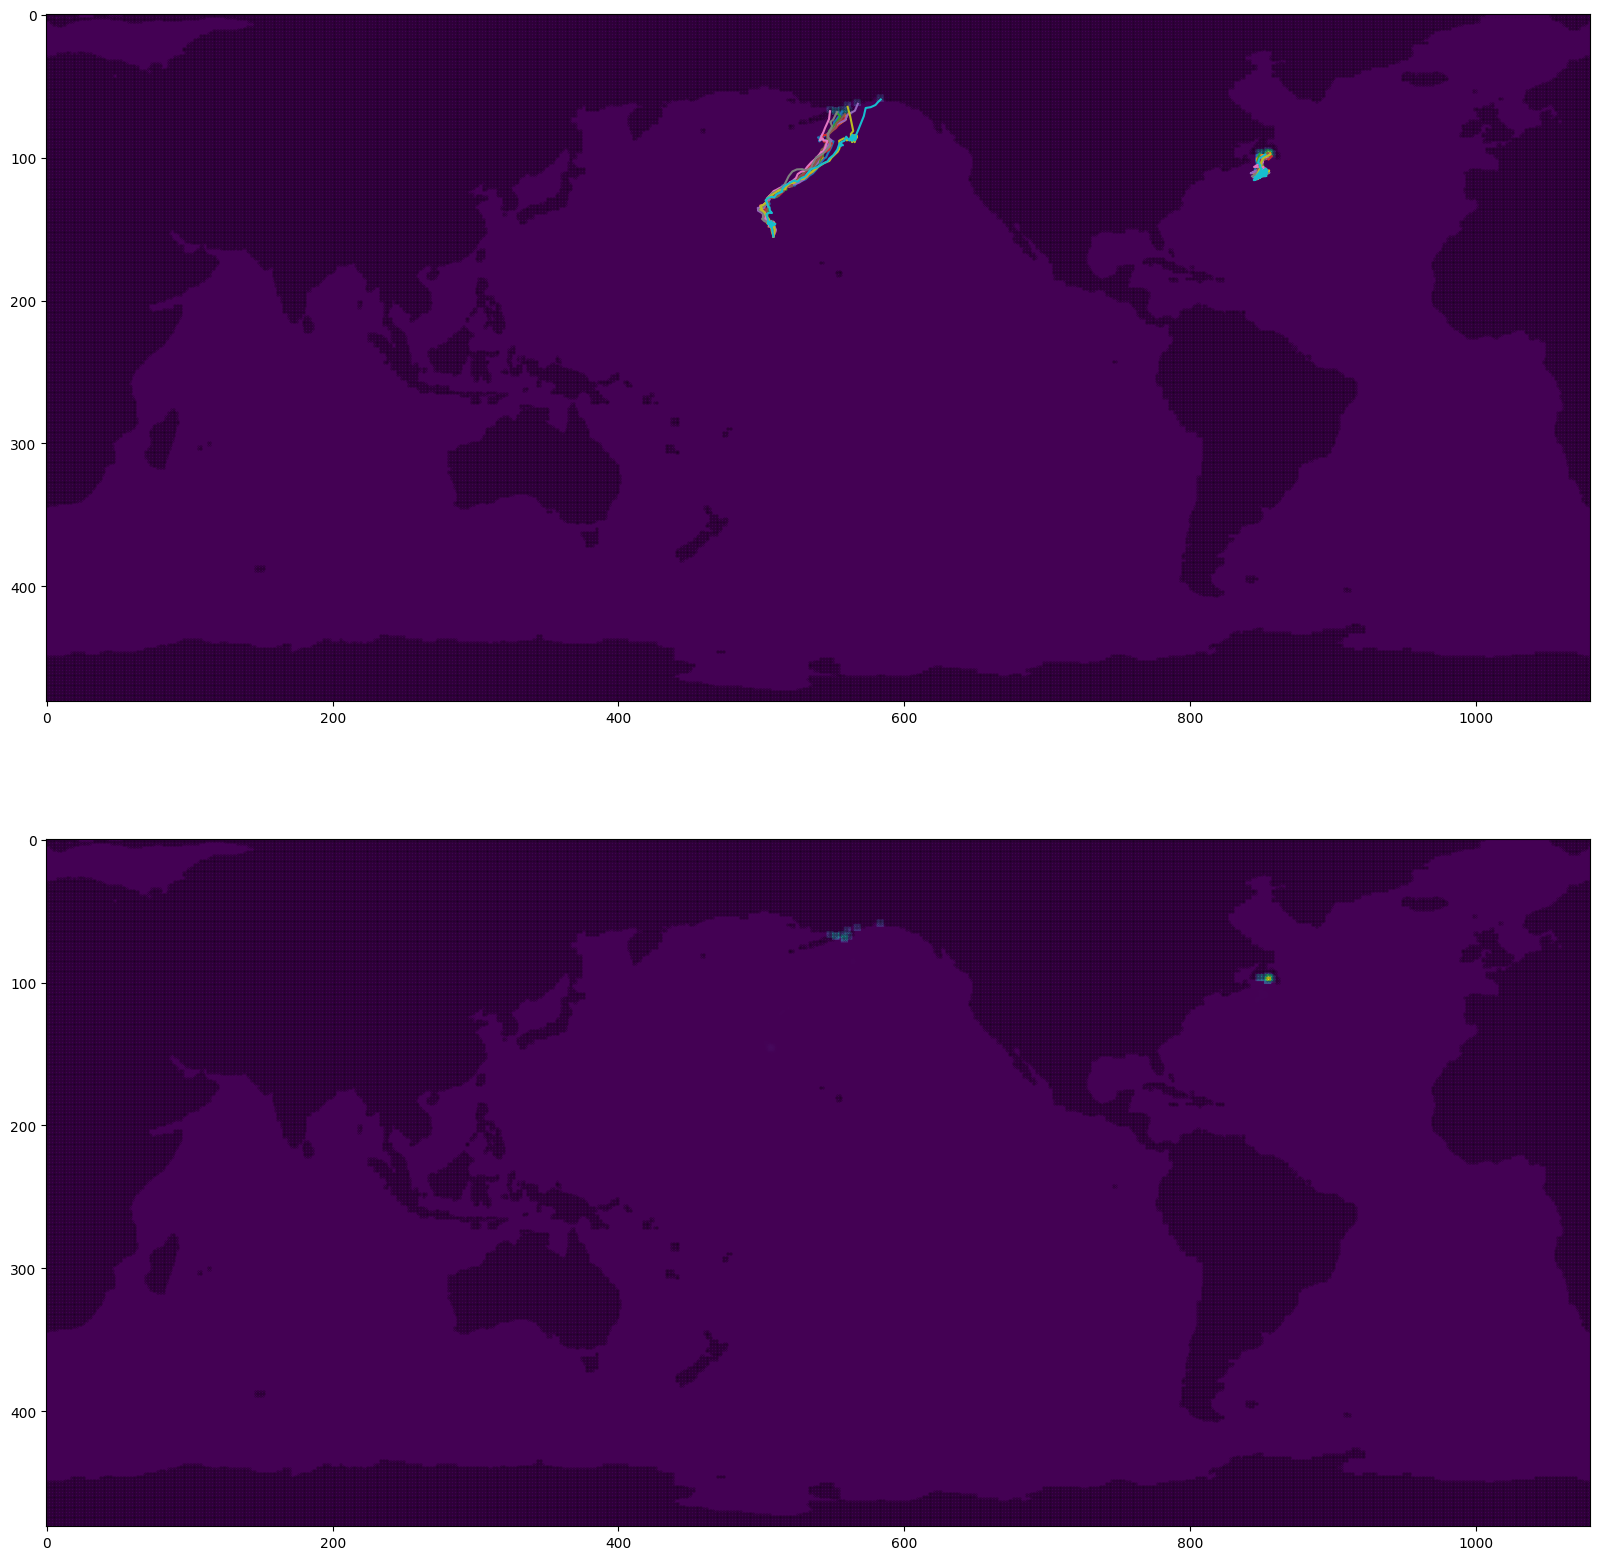

In [205]:
# checking coastal prevalence

def get_random_pos():
    isValid = False
    while (not isValid):
        la = np.random.rand() * 158 - 79
        lo = np.random.rand() * 358 - 179
        isValid = True
        c_r, c_c, c_y = ll_to_current_rc(la, lo)
        for i in range(max(int(c_y)-5, 0), min(int(c_y)+6, 480)):
            for j in range(max(int(c_c)-5, 0), min(int(c_c)+6, 1080)):
                if (is_land[i][j] > 0):
                    isValid = False

    return la, lo
        

fig, [ax, ax2] = plt.subplots(2, figsize=(21.6, 19.64))

coastal_prev = np.zeros((481, 1080))

for initialization in range(2):
    print(initialization)
    latitude, longitude = get_random_pos()
    init_latitude = latitude
    init_longitude = longitude
    print('latitude: ' + str(latitude) + ' longitude: ' + str(longitude))
    for o in range(10):
        print('path ' + str(o))
        latitude = init_latitude
        longitude = init_longitude
        curr_map_c = []
        curr_map_y = []
        for i in range(20000):
            c_r, c_c, c_y = ll_to_current_rc(latitude, longitude)
            curr_map_y.append(c_y)
            curr_map_c.append(c_c)

            for j in range(int(c_y) - 2, int(c_y) + 3):
                for k in range(int(c_c) - 2, int(c_c) + 3):
                    coastal_prev[j][k] += 1
            
            if (is_land[int(c_y)][int(c_c)] > 0):
                for j in range(int(c_y) - 2, int(c_y) + 3):
                    for k in range(int(c_c) - 2, int(c_c) + 3):
                        coastal_prev[j][k] += 1000
                break
            du, dv = current_vector(latitude, longitude)
            latitude += du * step_scale_factor + np.random.rand() * random_scale_factor
            longitude += dv * step_scale_factor + np.random.rand() * random_scale_factor
        ax.plot(curr_map_c, curr_map_y)

ax.scatter(land_x, land_y, c='black', s=0.01)
ax.imshow(coastal_prev)
ax2.scatter(land_x, land_y, c='black', s=0.01)
ax2.imshow(coastal_prev)